In [17]:
import yaml
import subprocess
import sys

# Path to the environment.yml file
YAML_FILE = "environment.yml"

def install_packages_from_yaml(yaml_file):
    """Reads environment.yml, extracts pip dependencies, and installs them."""
    try:
        # Load the YAML file
        with open(yaml_file, "r") as file:
            env_data = yaml.safe_load(file)

        # Extract pip dependencies
        dependencies = env_data.get("dependencies", [])
        pip_packages = []

        for dep in dependencies:
            if isinstance(dep, dict) and "pip" in dep:
                pip_packages.extend(dep["pip"])
            elif isinstance(dep, str) and not dep.startswith("python"):  # Ignore Python version
                pip_packages.append(dep)

        if not pip_packages:
            print("✅ No pip packages found in environment.yml.")
            return

        # Install packages via pip
        for package in pip_packages:
            try:
                subprocess.run([sys.executable, "-m", "pip", "install", package], check=True)
                print(f"✅ Successfully installed: {package}")
            except subprocess.CalledProcessError:
                print(f"Did not install: {package}")

        print("\n🚀 All dependencies installed successfully!")

    except Exception as e:
        print(f"❌ Error reading {yaml_file}: {e}")

# Run the installation
install_packages_from_yaml(YAML_FILE)

✅ Successfully installed: pip
Did not install: os
✅ Successfully installed: kaggle==1.6.17
Did not install: random
Did not install: zipfile
Did not install: glob
Did not install: PIL
✅ Successfully installed: matplotlib==3.10.0
✅ Successfully installed: scikit-learn
✅ Successfully installed: torch==2.6.0+cu124
✅ Successfully installed: torchvision==0.21.0+cu124

🚀 All dependencies installed successfully!


In [3]:
import os
import kaggle
import random
import shutil
import zipfile
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from breast_cancer_dataset import BreastCancerDataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [4]:
# Define paths
DATA_DIR = "BreastHistopathology"
ZIP_FILE = "BreastHistopathology_Small.zip"
CLASS_LABELS = ["0", "1"]  # Non-cancerous (0), Cancerous (1)

def extract_dataset():
    """Extracts dataset and ensures proper folder structure inside 'BreastHistopathology/'."""

    # 1️⃣ Ensure ZIP file exists before extraction
    if not os.path.exists(ZIP_FILE):
        raise FileNotFoundError(f"❌ {ZIP_FILE} not found! Ensure it is placed in the project directory.")

    # 2️⃣ Extract dataset if not already extracted
    if not os.path.exists(DATA_DIR):
        print("📂 Extracting dataset...")
        with zipfile.ZipFile(ZIP_FILE, "r") as zip_ref:
            zip_ref.extractall(".")  # Extract into the current directory
        print("✅ Extraction complete!")

    # 3️⃣ Ensure `BreastHistopathology/` exists
    if not os.path.exists(DATA_DIR):
        os.makedirs(DATA_DIR)

    # 4️⃣ Move `0/` and `1/` inside `BreastHistopathology/`
    for class_label in CLASS_LABELS:
        if os.path.exists(class_label):  # If `0/` or `1/` is at the root level
            target_path = os.path.join(DATA_DIR, class_label)
            shutil.move(class_label, target_path)  # Move it inside `BreastHistopathology/`
            print(f"📁 Moved `{class_label}/` into `{DATA_DIR}/`")

    # 5️⃣ Verify dataset structure
    num_images = len(glob(os.path.join(DATA_DIR, "**", "*.png"), recursive=True))
    if num_images == 0:
        raise RuntimeError(f"❌ No images found in {DATA_DIR}. Check if the ZIP file contains images.")

    print(f"✅ Dataset is ready with {num_images} images.")

# Run the dataset check and extraction
extract_dataset()

# ✅ Get all image paths
all_image_paths = glob(os.path.join(DATA_DIR, "**", "*.png"), recursive=True)
print(f"✅ Total images found: {len(all_image_paths)}")

# ✅ Count images in each class
normal_paths = glob(os.path.join(DATA_DIR, "0", "*.png"), recursive=True)  # Non-cancerous images
cancerous_paths = glob(os.path.join(DATA_DIR, "1", "*.png"), recursive=True)  # Cancerous images

# ✅ Display dataset breakdown
print(f"🔹 Non-cancerous images (for training): {len(normal_paths)}")
print(f"🔹 Cancerous images (for testing): {len(cancerous_paths)}")

# ✅ Now use `normal_paths` for training & validation, and `cancerous_paths` for testing


📂 Extracting dataset...
✅ Extraction complete!
📁 Moved `0/` into `BreastHistopathology/`
📁 Moved `1/` into `BreastHistopathology/`
✅ Dataset is ready with 1000 images.
✅ Total images found: 1000
🔹 Non-cancerous images (for training): 900
🔹 Cancerous images (for testing): 100


In [5]:
# Get all image paths
all_image_paths = glob(os.path.join(DATA_DIR, "**", "*.png"), recursive=True)
print(f"✅ Total images found: {len(all_image_paths)}")

# Split into Train (80%), Validation (10%), Test (10%)
train_paths, test_paths = train_test_split(all_image_paths, test_size=0.2, random_state=42)
val_paths, test_paths = train_test_split(test_paths, test_size=0.5, random_state=42)

print(f"🔹 Train set: {len(train_paths)} images")
print(f"🔹 Validation set: {len(val_paths)} images")
print(f"🔹 Test set: {len(test_paths)} images")

# Define image preprocessing (resize, normalize)
transform = transforms.Compose([
    transforms.Resize((64, 64), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Create PyTorch Datasets
train_dataset = BreastCancerDataset(train_paths, transform=transform)
val_dataset = BreastCancerDataset(val_paths, transform=transform)
test_dataset = BreastCancerDataset(test_paths, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

print("✅ DataLoaders ready!")

✅ Total images found: 1000
🔹 Train set: 800 images
🔹 Validation set: 100 images
🔹 Test set: 100 images
✅ DataLoaders ready!


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
# Define fraction to use for quick testing
fraction = 1.0 # Use only 100% of the small dataset

# Reduce dataset size while maintaining the same split ratio
def reduce_dataset_size(image_paths, fraction):
    new_size = max(1, int(len(image_paths) * fraction))  # Ensure at least 1 image
    return random.sample(image_paths, new_size)

# Reduce train, val, and test sets
train_paths = reduce_dataset_size(train_paths, fraction)
val_paths = reduce_dataset_size(val_paths, fraction)
test_paths = reduce_dataset_size(test_paths, fraction)

print(f"🔹 New Train set: {len(train_paths)} images")
print(f"🔹 New Validation set: {len(val_paths)} images")
print(f"🔹 New Test set: {len(test_paths)} images")

# Create PyTorch Datasets with reduced data
train_dataset = BreastCancerDataset(train_paths, transform=transform)
val_dataset = BreastCancerDataset(val_paths, transform=transform)
test_dataset = BreastCancerDataset(test_paths, transform=transform)

# Create DataLoaders with reduced dataset
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

print("✅ Reduced DataLoaders ready for quick testing!")

🔹 New Train set: 800 images
🔹 New Validation set: 100 images
🔹 New Test set: 100 images
✅ Reduced DataLoaders ready for quick testing!


In [7]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(ConvVAE, self).__init__()

        # Encoder (Convolutional Feature Extractor)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(256*4*4, latent_dim)
        self.fc_logvar = nn.Linear(256*4*4, latent_dim)
        self.fc_z = nn.Linear(latent_dim, 256*4*4)

        # Decoder (Transposed Conv for Image Reconstruction)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()  # Output in range [-1,1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        z = self.fc_z(z).view(-1, 256, 4, 4)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

In [8]:
# Load a saved model checkpoint
def load_trained_vae(model_path, latent_dim=64, device='cpu'):
    model = ConvVAE(latent_dim=latent_dim).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(f"Model loaded from {model_path}")
    return model

# Preliminary model evaluation based on sum total reconstruction loss
def evaluate_vae(model, dataloader, device='cpu'):
    model.eval()
    model.to(device)

    total_recon_loss = 0
    num_samples = 0

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            recon_images, _, _ = model(images)

            recon_loss = F.mse_loss(recon_images, images, reduction='sum')
            total_recon_loss += recon_loss.item()
            num_samples += images.size(0)

    avg_recon_loss = total_recon_loss / num_samples
    print(f"Average Reconstruction Loss: {avg_recon_loss:.4f}")

    return avg_recon_loss

# Visualize Images (Expectation vs. Reconstruction)
def visualize_reconstruction(model, dataloader, action, device='cpu', num_images=10):
    model.eval()
    model.to(device)

    images, _ = next(iter(dataloader))
    images = images.to(device)
    indices = torch.randperm(images.size(0))[:num_images]
    images = images[indices]

    with torch.no_grad():
        recon_images, _, _ = model(images)

    images = (images + 1) / 2
    recon_images = (recon_images + 1) / 2

    fig, axes = plt.subplots(2, num_images, figsize=(15, 4))

    for i in range(num_images):
        axes[0, i].imshow(images[i].permute(1, 2, 0).cpu().numpy())
        axes[0, i].axis("off")
        axes[1, i].imshow(recon_images[i].permute(1, 2, 0).cpu().numpy())
        axes[1, i].axis("off")

    axes[0, 0].set_title("Original Images")
    axes[1, 0].set_title("Reconstructed Images")

    plot_name = f"{action}_sample_results.png"
    plt.savefig(plot_name)
    plt.show()

In [9]:
# Train model
def train_vae(model, dataloader, num_epochs=100, device='cpu', save_path="vae_colab_64x64_64L.pth"):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

    train_losses = []  # Store total loss
    recon_losses = []  # Store reconstruction loss
    kl_losses = []  # Store KL divergence loss

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_recon_loss = 0
        total_kl_loss = 0

        print(f"Epoch {epoch+1}/{num_epochs}:", end=" ")

        # Raw KL-div contribution to total loss
        kl_weight = 1.0
        # [Optional] KL Annealing: Linearly increase from 0.01 → 1.0 over training
        # kl_weight = min(1.0, 0.01 + (epoch / num_epochs))

        for images, _ in dataloader:
            print(".", end="")
            images = images.to(device)

            optimizer.zero_grad()
            recon_x, mu, logvar = model(images)

            # Compute Losses
            recon_loss = F.mse_loss(recon_x, images, reduction='sum')
            kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

            # Total loss is weighted sum of reconstruction loss and KL divergence
            loss = recon_loss + kl_weight * kl_div

            # Backpropagation
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_div.item()

        avg_loss = total_loss / len(dataloader.dataset)
        avg_recon_loss = total_recon_loss / len(dataloader.dataset)
        avg_kl_loss = total_kl_loss / len(dataloader.dataset)

        train_losses.append(avg_loss)
        recon_losses.append(avg_recon_loss)
        kl_losses.append(avg_kl_loss)

        print(f" | Loss: {avg_loss:.4f} (Recon: {avg_recon_loss:.4f}, KL: {avg_kl_loss:.4f}, KL weight: {kl_weight:.3f})")

        # Save model every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), save_path)
            print(f"Model checkpoint saved at epoch {epoch+1}")

    # Save final model
    torch.save(model.state_dict(), save_path)
    print("Training complete! Model saved.")

    # Plot Training Losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(2, num_epochs + 1), train_losses[1:], label="Total Loss", marker='o', linestyle='-')
    plt.plot(range(2, num_epochs + 1), recon_losses[1:], label="Reconstruction Loss", marker='o', linestyle='--')
    plt.plot(range(2, num_epochs + 1), kl_losses[1:], label="KL Divergence Loss", marker='o', linestyle=':')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("VAE Training Loss Breakdown")
    plt.legend()
    plt.grid()
    plt.savefig("Training_Loss_Breakdown.png")
    plt.show()

    return train_losses, recon_losses, kl_losses

Epoch 1/50: ........ | Loss: 210822.5075 (Recon: 4455.0101, KL: 206367.4911, KL weight: 1.000)
Epoch 2/50: ........ | Loss: 2357.5933 (Recon: 2276.7953, KL: 80.7980, KL weight: 1.000)
Epoch 3/50: ........ | Loss: 1538.6945 (Recon: 1475.5213, KL: 63.1732, KL weight: 1.000)
Epoch 4/50: ........ | Loss: 1153.0359 (Recon: 1086.8418, KL: 66.1941, KL weight: 1.000)
Epoch 5/50: ........ | Loss: 936.2282 (Recon: 876.5702, KL: 59.6580, KL weight: 1.000)
Epoch 6/50: ........ | Loss: 819.5882 (Recon: 769.6405, KL: 49.9477, KL weight: 1.000)
Epoch 7/50: ........ | Loss: 753.8128 (Recon: 703.8698, KL: 49.9429, KL weight: 1.000)
Epoch 8/50: ........ | Loss: 715.3447 (Recon: 665.0286, KL: 50.3161, KL weight: 1.000)
Epoch 9/50: ........ | Loss: 682.1630 (Recon: 634.1603, KL: 48.0027, KL weight: 1.000)
Epoch 10/50: ........ | Loss: 669.6293 (Recon: 620.3415, KL: 49.2878, KL weight: 1.000)
Model checkpoint saved at epoch 10
Epoch 11/50: ........ | Loss: 649.6390 (Recon: 601.3685, KL: 48.2705, KL weight:

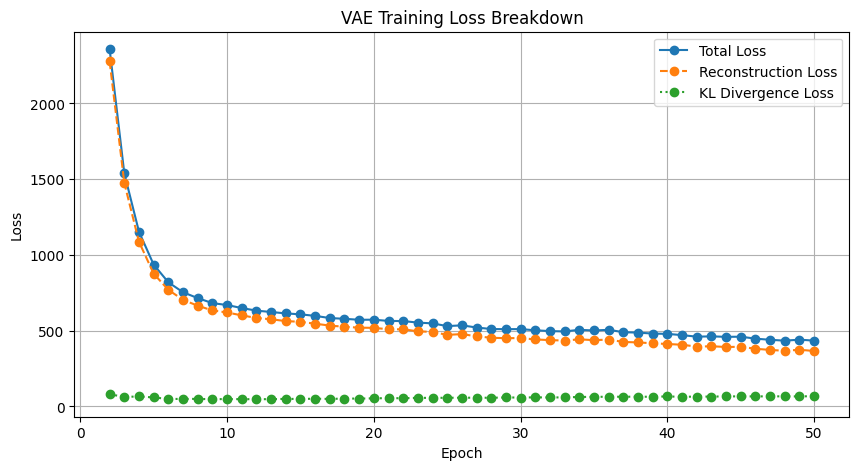

In [10]:
# Select the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Parameters
image_shape = (64, 64)
epochs = 50
latent_dim = 64

# Model name
model_name = f"Vanilla_ConvVae_{image_shape[0]}x{image_shape[1]}_{latent_dim}L_{epochs}e.pth"

# Define the model
vae_model = ConvVAE(latent_dim=latent_dim)
#vae_model = load_trained_vae(model_name, latent_dim=latent_dim)

# Train the model
train_losses = train_vae(vae_model, train_loader, num_epochs=epochs, device=device, save_path=model_name)



---



In [11]:
# [Optional] Load VAE model
# vae_model = load_trained_vae("vae_model_50x50.pth")

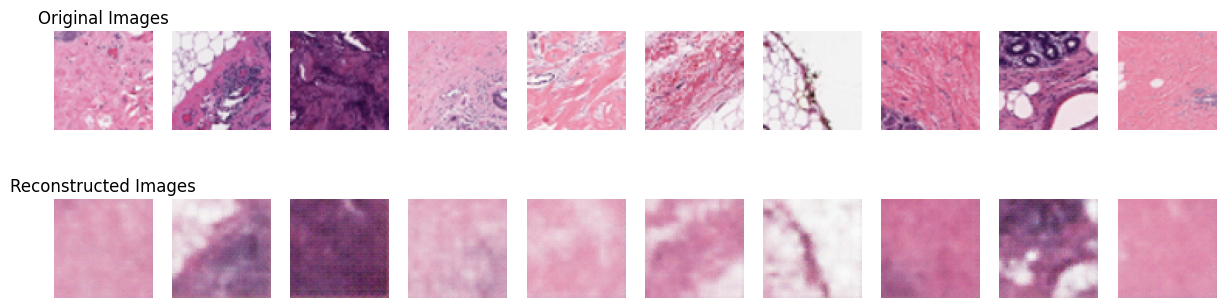

In [12]:
# Visualize reconstruction on training subset
visualize_reconstruction(vae_model, train_loader, 'training')

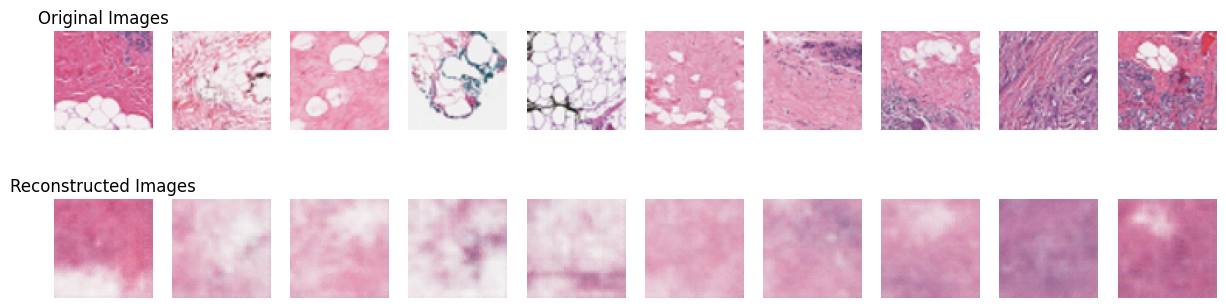

In [13]:
# Visualize reconstruction on validation subset
visualize_reconstruction(vae_model, val_loader, 'validation')

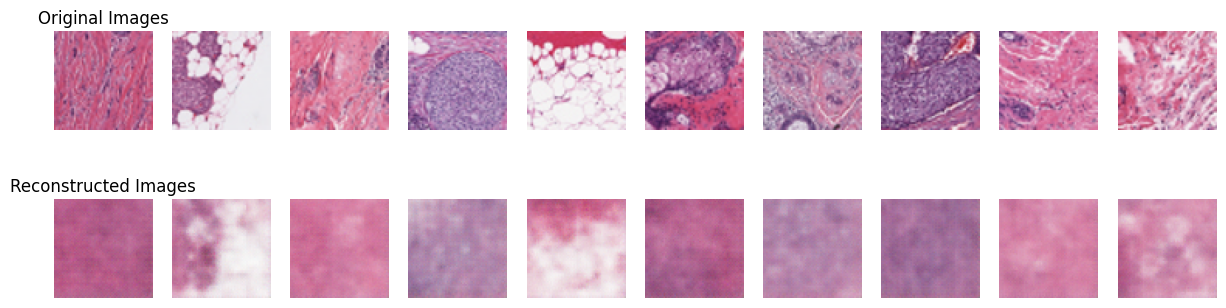

In [14]:
# Visualize reconstruction on testing subset
visualize_reconstruction(vae_model, test_loader, 'testing')

In [15]:
# Evaluate model performance on training subset
# evaluate_vae(vae_model, train_loader)

# Evaluate model performance on validation subset
# evaluate_vae(vae_model, val_loader)

# Evaluate model performance on testing subset
evaluate_vae(vae_model, test_loader)

Average Reconstruction Loss: 502.2774


502.2773828125


---
